# Anomaly detection using credit card fraud detection data

In [ ]:
'''
- Data acquired from Kaggle:https://www.kaggle.com/mlg-ulb/creditcardfraud
  it contains 2-day transactions made by credit cards in September 2013 by European cardholders.
- Data contain 30 features and binary class notification; y0=normal transaction, y1=Fraud.

- Conducted Anomaly detection using Multivariate Gaussian distribution method.
- Model evaluation was conducted using testset and acquired AUC 0.81

Q.Anomaly detection vs. supervised classification, which one should I apply?
Anomaly detection can be suitable when there's a very small number of positive examples(anomalies)
since it's hard for a model to learn the positive examples from the sample given. 
Also, anomalies might look nothing like any other in the training dataset. 
In this dataset, y1 takes up 0.17%, highly imbalanced dataset.

### references
-Andrew Ng's Anomaly detection ML lectures (https://www.youtube.com/watch?v=086OcT-5DYI&list=PLwgXNx7TiGV6UH3aEzmdZwzFRwvEnRb0N&ab_channel=ArtificialIntelligence-AllinOne)
- Sachin Shelar's Kaggle notebook (https://www.kaggle.com/shelars1985/anomaly-detection-using-gaussian-distribution)

'''

In [288]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import skew 
from scipy import stats 

from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from scipy.stats import multivariate_normal

### 1. Load dataset

In [74]:
# Load the dataset
df=pd.read_csv('creditcard.csv')

In [48]:
df.head()
#-> V1~V28 transformed variables are from PCA.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. Exploring Data Analysis

In [49]:
# check the datatype of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [50]:
pd.set_option("display.max_columns",31)
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [51]:
# total number of samples
len(df)

284807

In [52]:
# Check if there's any missing values
df.isna().sum().sum()

0

In [53]:
# check the balance of dataset between class 0 and 1
obj=pd.DataFrame(df.Class.value_counts())
obj['%']=(obj['Class']/sum(obj['Class'])*100).round(2)
obj

,Class,%
0,284315,99.83
1,492,0.17


In [56]:
# Check the distribution of dataset to see if it needs to be transformed
skewness=[]
for col in df:
    print(col, " ", skew(df[col]))
    #skewness.append(skew(df[col]))

Time   -0.03556743068120296
V1   -3.2806500243599563
V2   -4.624841215356954
V3   -2.2401436419416556
V4   0.6762885361363855
V5   -2.4258887193785577
V6   1.8265710448869008
V7   2.5538939666831117
V8   -8.521899311980174
V9   0.5546768505565418
V10   1.1871343376109695
V11   0.3565039778679557
V12   -2.2783889356830715
V13   0.0652331143394307
V14   -1.9951653322115102
V15   -0.30842135775467616
V16   -1.1009604775565411
V17   -3.8448942237357953
V18   -0.25987889937453285
V19   0.10919118489771402
V20   -2.0371445699300104
V21   3.5929722697554753
V22   -0.21325649967250146
V23   -5.875109397316075
V24   -0.5524963913014509
V25   -0.4157904004474158
V26   0.5766895799228516
V27   -1.1702027792556084
V28   11.19203224646587
Amount   16.97763503663315
Class   23.99745292182408


In [75]:
# Transform highly skewed variables into normal distribution using boxcox.

df.V2, fitted_lambda=stats.boxcox(df.V2+72.716)
print('V2: ',skew(df.V2))

df.V8, fitted_lambda=stats.boxcox(df.V8+73.217)
print('V8: ',skew(df.V8))

df.V23, fitted_lambda=stats.boxcox(df.V23+44.808)
print('V23: ',skew(df.V23))

df.V28, fitted_lambda=stats.boxcox(df.V28+15.431)
print('V28: ', skew(df.V28))

df.Amount, fitted_lambda=stats.boxcox(df.Amount+0.01)
print('Amount: ', skew(df.Amount))

V2:  0.8418382473093441
V8:  2.5300240681811546
V23:  2.7790923344867022
V28:  3.480387171704521
Amount:  0.002200914039098123


### 3. Feature Selection

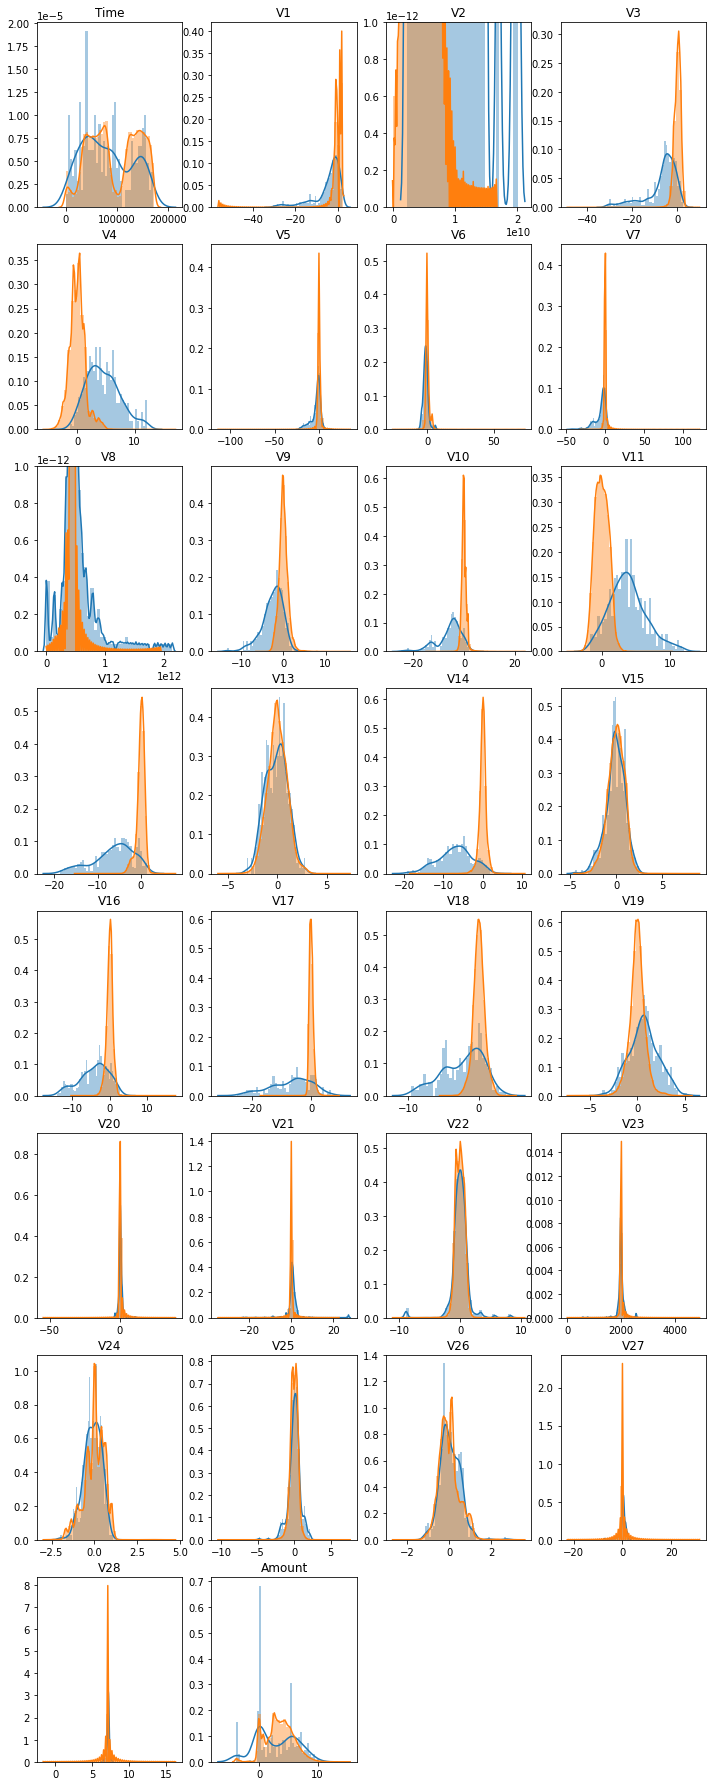

In [195]:
# density plots for all the features colored by class to see the separation 
df_features=df.columns[0:-1]

plt.figure(figsize=(12,32))
gs = gridspec.GridSpec(8, 4)
for i, col in enumerate(df[df_features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=40)
    sns.distplot(df[col][df.Class == 0], bins=40)
    ax.set_xlabel('')
    ax.set_title(str(col))
plt.show()

In [131]:
# Feature importance using RandomForest classifier
X,y=df.drop(['Class'],axis=1), df.Class

#define the model
RF=RandomForestClassifier()

#fit the model
RF.fit(X, y)

# acquire importance
importance_RF=RF.feature_importances_

In [157]:
importance_RF_df=pd.DataFrame(importance_RF)
importance_RF_df['Feature']=list(df.columns[0:30])
importance_RF_df.columns=['importance','Feature']
importance_RF_df

,importance,Feature
0,0.011974,Time
1,0.013955,V1
2,0.019161,V2
3,0.018740,V3
4,0.038617,V4
5,0.012448,V5
6,0.010855,V6
7,0.028770,V7
8,0.012680,V8
9,0.038677,V9


In [265]:
# feature importance in sorted way
importance_RF_df.sort_values('importance',ascending=False)

,importance,Feature
17,0.165703,V17
12,0.121256,V12
14,0.108193,V14
11,0.072243,V11
10,0.069046,V10
16,0.069031,V16
9,0.038677,V9
4,0.038617,V4
18,0.037036,V18
7,0.028770,V7


Text(0, 0.5, 'Feature')

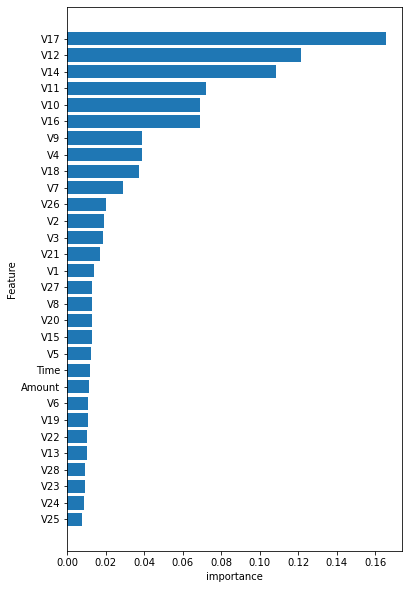

In [178]:
# bar plot of feature impoartance for each feature.
plt.figure(figsize=(6,10))
df_sorted=importance_RF_df.sort_values('importance',ascending=True)
plt.barh('Feature', 'importance',data=df_sorted)
plt.xlabel('importance')
plt.ylabel('Feature')

In [266]:
# drop features whose feature importance belows 0.02
df_selected=df.drop(columns=['V25','V24','V23','V28','V13','V22','V19','V6','Amount','Time','V5','V15','V20','V8','V27','V1','V21','V3','V2','V26'])
df_selected

,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
0,1.378155,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,0.448154,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,0.379780,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,-0.863291,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,0.403034,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0
...,...,...,...,...,...,...,...,...,...,...,...
284802,-2.066656,-4.918215,1.914428,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,0
284803,-0.738589,0.024330,0.584800,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,0
284804,-0.557828,-0.296827,0.432454,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,0
284805,0.689799,-0.686180,0.392087,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,0


### 4. Multivariate Gaussian Distribution

$\mu\in\mathbb{R}$
<br>
$\Sigma \in \mathbb{R}^{nxn} $ (covariance matrix)
<br>
$p(x;\mu,{\boldsymbol\Sigma})=\frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma|}}
\exp\left(-\frac{1}{2}({x}-{m})^T{\boldsymbol\Sigma}^{-1}({x}-{m})
\right)$

procedures:
1. Choose features that might be indicative of anomalis examples (already done above feature importance section)
2. Fit paraters; $\mu$, $\Sigma$ based on the training set
3. On cross-validation set, predict <br>
   y=1, if p(x) $< \epsilon$ <br>
   y=0, if p(x) $\geq \epsilon$ <br>
   Select best epsilon using evaluation metrics.<br>
4. On testset, Evaluate the model using evaluation metrics.

Pro and Cons of Multivariate Gaussian distribution:
it automatically captures correlations between features.
However, it computationaly more expensive and the number of samples should be enough.

In [454]:
# Need to split data into training/cv/test set

In [267]:
# split the data by class
df_selected_y0=df_selected[df_selected['Class']==0] #store class=0
df_selected_y1=df_selected[df_selected['Class']==1] #store class=1, Anomaly data

print('class 0 :',len(df_selected_y0))
print('class 1 :',len(df_selected_y1))

class 0 : 284315
class 1 : 492


In [268]:
# Split data into training/cv/test set based on the ratio below

'''  ---------------------------------------------------
        training    |       cv set    |     test set    |
     60% y0 + 0% y1 | 20% y0 + 50% y1 | 20% y0 + 50% y1 |
---------------------------------------------------------
'''
# class=1 (anomaly)
index=len(df_selected_y1)//2 #set index at 50%

df_selected_y1_cv=df_selected_y1[:index]
print(df_selected_y1_cv.shape)

df_selected_y1_test=df_selected_y1[index:]
print(df_selected_y1_test.shape)

# class=0
index1=len(df_selected_y0)*60//100 #set index1 at 60%
index2=len(df_selected_y0)*80//100 # set index2 at 80%

df_selected_y0_train=df_selected_y0[:index1] 
print(df_selected_y0_train.shape)  

df_selected_y0_cv=df_selected_y0[index1:index2]
print(df_selected_y0_cv.shape)

df_selected_y0_test=df_selected_y0[index2:]
print(df_selected_y0_test.shape)


#combine y0 and y1 for cv and testset
df_selected_cv=pd.concat([df_selected_y0_cv,df_selected_y1_cv], axis=0)
print(df_selected_cv.shape)   

df_selected_test=pd.concat([df_selected_y0_test,df_selected_y1_test], axis=0)
print(df_selected_test.shape)   

#store class only
df_selected_cv_y=df_selected_cv['Class']
print(df_selected_cv_y.shape)

df_selected_test_y=df_selected_test['Class']
print(df_selected_test_y.shape)

#store features only

df_selected_train=df_selected_y0_train.drop(labels=['Class'], axis=1)
print('training set : ',df_selected_train.shape)  #final training set

df_selected_cv.drop(labels=['Class'], axis=1, inplace=True)
print('cv set: ', df_selected_cv.shape) #final cv set

df_selected_test.drop(labels=['Class'], axis=1, inplace=True)
print('test set: ', df_selected_test.shape)  #final test set

(246, 11)
(246, 11)
(170589, 11)
(56863, 11)
(56863, 11)
(57109, 11)
(57109, 11)
(57109,)
(57109,)
training set :  (170589, 10)
cv set:  (57109, 10)
test set:  (57109, 10)


In [272]:
# define parameters and calculate P
def estimate_Gaussian(dataset):
    mu=np.mean(dataset, axis=0)
    sigma=np.cov(dataset.T)
    return mu, sigma
    
def multivariate_Gaussian(dataset, mu, sigma):
    rv=multivariate_normal(mean=mu, cov=sigma)
    return rv.pdf(dataset)

#Fit model P(x) on training set
mu, sigma=estimate_Gaussian(df_selected_train)

#calculate p(x)
p=multivariate_Gaussian(df_selected_train, mu,sigma)
p_cv=multivariate_Gaussian(df_selected_cv, mu,sigma)
p_test=multivariate_Gaussian(df_selected_test, mu,sigma)

In [341]:
p_cv_df=pd.DataFrame(p_cv)
p_cv_df.columns=['epsilon']
p_cv_df

,epsilon
0,2.727946e-06
1,2.273817e-05
2,1.452182e-06
3,1.016365e-05
4,2.138477e-06
...,...
57104,1.808402e-72
57105,6.508317e-70
57106,5.928160e-67
57107,1.410930e-05


In [389]:
## select threshold of epsilon
''' first, run all the p_cv to find the highest f1 score.
    after finding the epsilon value, narrow down the range of epsilon to find the best threshold
'''
def threshold_Selection(prob, dataset, epsilons):
    best_epsilon=0
    best_f1=0
    f=0
     
    for epsilon in epsilons:
        predict=prob<epsilon
    
        f=f1_score(dataset, predict, average='binary') # show the F1 score of positive class(anomaly)
        if f>best_f1:   #update the best f1_score
            best_f1=f
            best_epsilon=epsilon
    return best_f1, best_epsilon

In [390]:
# Find the epsilon based on the cv dataset.
best_f1, best_epsilon=threshold_Selection(p_cv,df_selected_cv_y, p_cv)    

In [391]:
# best epsilon value selected
#best_f1, best_epsilon

(0.8329809725158562, 1.3147682889428342e-64)

In [415]:
# Find the upper and lower values of best_epsilon selected above.
pd.options.display.float_format = "{:,.7e}".format
p_cv_sorted=pd.DataFrame(p_cv_df.sort_values('epsilon', ascending=True))
p_cv_sorted=p_cv_sorted.reset_index()
p_cv_sorted

print(p_cv_sorted[p_cv_sorted['epsilon']==1.3147682889428342e-64].index.tolist())
p_cv_sorted[226:229]

[227]


,index,epsilon
226,57081,1.0615060e-64
227,5384,1.3147683e-64
228,2401,2.3150819e-62


In [414]:
#tried apply different epsilon values but couldn't find any values giving the better result than above.

#epsilons=[1.09e-64,1.21e-64,1.24e-64,1.27e-64,1.30e-64]
#epsilons=[9.3e-64,1.5e-63,5.5e-63,9.3e-63,1.1e-62]

#best_f1_re, best_epsilon_re=threshold_Selection(p_cv,df_selected_cv_y, epsilons) 
#best_f1_re, best_epsilon_re

(0.8259958071278827, 9.9147883e-61)

In [316]:
# Evaluation metrics on cv dataset.
predict_cv=p_cv<best_epsilon
print('confusion_matrix')
print(confusion_matrix(df_selected_cv_y,predict_cv))
print(classification_report(df_selected_cv_y,predict_cv))
print ('AUC', roc_auc_score(df_selected_cv_y,predict_cv).round(2))

confusion_matrix
[[56833    30]
 [   49   197]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.87      0.80      0.83       246

    accuracy                           1.00     57109
   macro avg       0.93      0.90      0.92     57109
weighted avg       1.00      1.00      1.00     57109

AUC 0.9


In [317]:
# Evaluation metrics on test set (unseen data)

predict_test=p_test<best_epsilon
print('confusion_matrix')
print(confusion_matrix(df_selected_test_y,predict_test))
print(classification_report(df_selected_test_y,predict_test))
print ('AUC', roc_auc_score(df_selected_test_y,predict_test).round(2))

confusion_matrix
[[56847    16]
 [   91   155]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.91      0.63      0.74       246

    accuracy                           1.00     57109
   macro avg       0.95      0.81      0.87     57109
weighted avg       1.00      1.00      1.00     57109

AUC 0.81


In [416]:
df_selected_test['V14'].index

Int64Index([227869, 227870, 227871, 227872, 227873, 227874, 227875, 227876,
            227877, 227878,
            ...
            274382, 274475, 275992, 276071, 276864, 279863, 280143, 280149,
            281144, 281674],
           dtype='int64', length=57109)

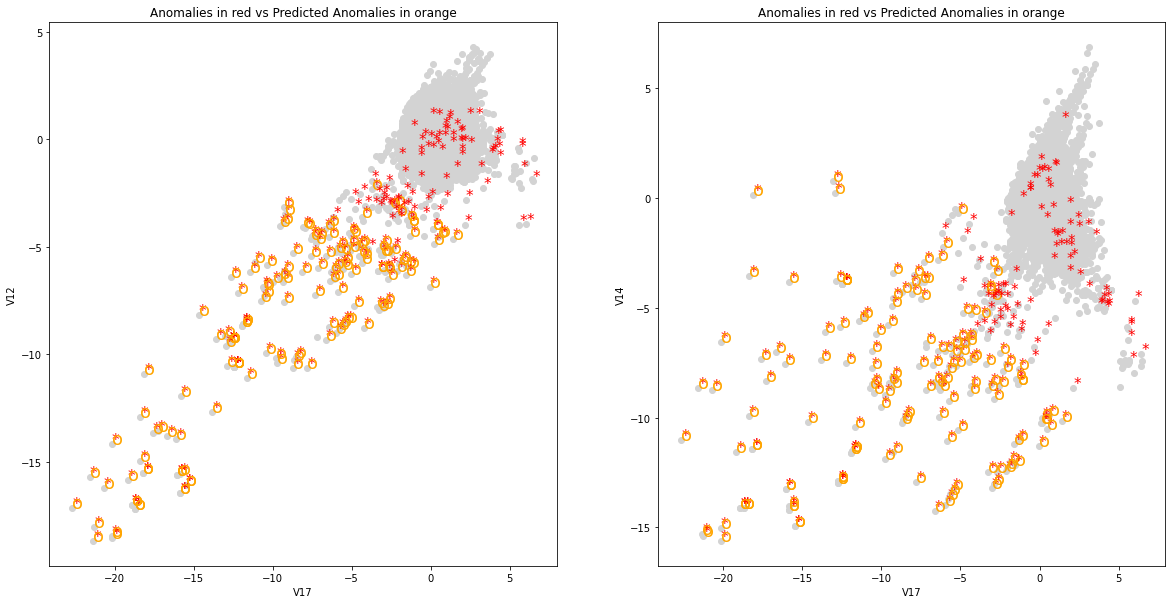

In [453]:
# Visualization of result on test dataset.
# scatter plots; V17 vs V12 and V17 vs V14 (features having high feature importances)

fig=plt.figure(figsize=(20,10))  # define the property of figure
ax1=fig.add_subplot(121)  # add a plot to the figure (V17 vs V12)
ax2=fig.add_subplot(122)  # add a plot to the figure (V17 vs V12)

ax1.scatter(df_selected_test['V17'],df_selected_test['V12'], color='lightGrey')
ax1.set_title('Anomalies in red vs Predicted Anomalies in orange')
ax1.set_xlabel('V17')
ax1.set_ylabel('V12')
for i, row in enumerate(df_selected_test['V17'].index):
    if df_selected_test_y[row]==1:      # Anomalies data (y=1)
        ax1.annotate('*', (df_selected_test['V17'][row],df_selected_test['V12'][row]),
                    fontsize=15, color='red')
    
        if predict_test[i]==True:      # Anomalies predicted by model.
            ax1.annotate('o',(df_selected_test['V17'][row],df_selected_test['V12'][row]),
                    fontsize=18, color='orange')   

ax2.scatter(df_selected_test['V17'],df_selected_test['V14'], color='lightGrey')
ax2.set_title('Anomalies in red vs Predicted Anomalies in orange')
ax2.set_xlabel('V17')
ax2.set_ylabel('V14')
for i, row in enumerate(df_selected_test['V17'].index):
    if df_selected_test_y[row]==1:      # Anomalies data (y=1)
        ax2.annotate('*', (df_selected_test['V17'][row],df_selected_test['V14'][row]),
                    fontsize=15, color='red')
    
        if predict_test[i]==True:      # Anomalies predicted by model.
            ax2.annotate('o',(df_selected_test['V17'][row],df_selected_test['V14'][row]),
                    fontsize=18, color='orange')   

# Model hardly captures area where lots of y0 exist in clustered. makes sense.
# false positive in that area.